In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 


from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
from graph_utils import plot_multiple,plot_xy

%matplotlib inline


# DATA PREPARATION

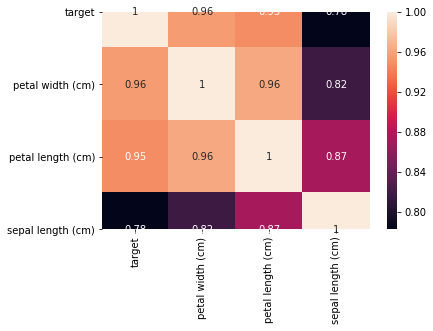

In [2]:
df = pd.DataFrame(load_iris().data, columns=load_iris().feature_names)
df["target"] = load_iris().target

correlated_features = abs(df.corr()["target"]).sort_values(ascending=False)

correlated_features = correlated_features[correlated_features>0.5]

df = df[correlated_features.keys()]

sns.heatmap(df.corr(),annot=True)

In [3]:
file_path = None

if not(file_path):
    X = np.array(df.drop('target',axis=1))
    y = np.array(df["target"])
else:
    df = pd.read_csv(file_path,keep_default_na=False,na_values="").drop("Unnamed: 0",axis=1)

df = pd.DataFrame(X)

for i in range(len(df.columns)-1):
    name = str(df.columns[i])+"_x_"+str(df.columns[i+1])
    df[name] = df[df.columns[i]] * df[df.columns[i+1]]

X = np.array(df)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)
print('Train set size',X_train.shape[0],'Test set size',X_test.shape[0])

Train set size 105 Test set size 45


In [5]:
def standardize(df,df_ref):
    return (df - df_ref.mean())/df_ref.std(ddof=1)

def destandardize(df,df_ref):
    return (df * df_ref.std(ddof=1)) + df_ref.mean()

X_train_t = np.transpose(X_train.copy())
X_test_t = np.transpose(X_test.copy())

for i,col in enumerate(X_train_t) :
    X_test_t[i] = standardize(X_test_t[i], col)
    X_train_t[i] = standardize(col, col)
    
X_train_modified = np.transpose(X_train_t)
X_test_modified = np.transpose(X_test_t)

y_train_modified = standardize(y_train,y_train)
y_test_modified = standardize(y_test,y_train)

# REGRESSIONS

In [6]:
def train_model(model,X_train,y_train,X_test,y_test,GS=False):
    reg = model.fit(np.array(X_train), y_train)
    if GS:
        print(model.best_params_)
    for i in range(X_test.shape[0]):
        y_hat_test = reg.predict(np.array(X_test))
        y_hat_train = reg.predict(np.array(X_train))
    return y_hat_test,y_hat_train

def run_models(X_train,y_train,X_test,y_test,models,GS=False,y_hat=None,y_hat_train=None):
    if not(y_hat):
        y_hat = {}
    if not(y_hat_train):
        y_hat_train = {}
    for model_name in models.keys():
        print(model_name)
        y_hat[model_name],y_hat_train[model_name] = train_model(models[model_name],X_train,y_train,X_test,y_test,GS=GS)  

    return y_hat,y_hat_train

def compute_mse(y_test,y_hat,dict_mse=None):
    if not(dict_mse):
        dict_mse = {}
    for model_name in models.keys():
        dict_mse[model_name] = accuracy_score(np.array(y_test).reshape(-1,1),np.array(np.round(y_hat[model_name])))
        
    return dict_mse

In [7]:
models = {"Logistic":LogisticRegression(),
          "Ridge":Ridge(),
          "Lasso":Lasso(),
          'RandomForest':RandomForestClassifier(),
          "Elastic Net":ElasticNet(),
          "LGBM":LGBMClassifier(n_estimators=2000),
          "MLP":MLPClassifier()
          }

y_hat,y_hat_train = run_models(X_train,y_train,X_test,y_test,models)


dict_mse=compute_mse(y_test,y_hat)
dict_mse_train=compute_mse(y_train,y_hat_train)

y_hat_modified,y_hat_modified_train = run_models(X_train_modified,y_train,X_test_modified,y_test,models)
dict_mse_modified = compute_mse(y_test,y_hat_modified)
dict_mse_modified_train = compute_mse(y_train,y_hat_modified_train)



Logistic
Ridge
Lasso
RandomForest
Elastic Net
LGBM
MLP


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Logistic
Ridge
Lasso
RandomForest
Elastic Net
LGBM
MLP


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [8]:
dict_mse_train

{'Logistic': 0.9809523809523809,
 'Ridge': 0.9904761904761905,
 'Lasso': 0.3047619047619048,
 'RandomForest': 1.0,
 'Elastic Net': 0.7523809523809524,
 'LGBM': 1.0,
 'MLP': 0.9428571428571428}

In [9]:
dict_mse

{'Logistic': 0.9777777777777777,
 'Ridge': 0.9777777777777777,
 'Lasso': 0.4,
 'RandomForest': 0.9555555555555556,
 'Elastic Net': 0.7777777777777778,
 'LGBM': 0.9555555555555556,
 'MLP': 0.8444444444444444}

In [10]:
dict_mse_modified_train

{'Logistic': 0.9619047619047619,
 'Ridge': 0.9809523809523809,
 'Lasso': 0.3047619047619048,
 'RandomForest': 1.0,
 'Elastic Net': 0.3047619047619048,
 'LGBM': 1.0,
 'MLP': 0.9619047619047619}

In [11]:
dict_mse_modified

{'Logistic': 0.9777777777777777,
 'Ridge': 0.9777777777777777,
 'Lasso': 0.4,
 'RandomForest': 0.9555555555555556,
 'Elastic Net': 0.4,
 'LGBM': 0.9555555555555556,
 'MLP': 0.9555555555555556}

# GridSearch

In [12]:

param_grid = {}
n_splits = 5

# MLP

In [13]:
param_grid["MLP"] = {
    'hidden_layer_sizes':[(i,) for i in range(100,1000,100)],
    'activation':['identity', 'tanh', 'relu'],
    'solver':["adam"],
    'learning_rate':["adaptive"],
    'max_iter':[2000],
    'early_stopping':[True],
    'alpha':[10**(-i) for i in range(0,6)]
    
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
MLP_GS = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid["MLP"], cv=gkf,verbose=1)

## LGBM

In [14]:
param_grid["LGBM"] = {
    'boosting_type':["gbdt"],
    'max_depth': [-1],
    'n_estimators':[200],
    'reg_alpha':[0],
    'reg_lambda':[0],
    'num_leaves':[i for i in range(2,100,2)],
    'learning_rate':[10**(-i) for i in range(0,3)],
    'subsample':[0.95],
    'colsample_bytree':[0.95]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
LGBM_GS = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid["LGBM"], cv=gkf,verbose=1)

## Ridge

In [15]:
param_grid["Ridge"] = {
    'alpha':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Ridge_GS = GridSearchCV(estimator=Ridge(), param_grid=param_grid["Ridge"], cv=gkf,verbose=1)

## Lasso

In [16]:
param_grid["Lasso"] = {
    'alpha':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Lasso_GS = GridSearchCV(estimator=Lasso(), param_grid=param_grid["Lasso"], cv=gkf,verbose=1)

## ElasticNet

In [17]:
param_grid["ElasticNet"] = {
    'alpha':[i/100 for i in range(1,100)],
    'l1_ratio':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train)
ElasticNet_GS = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid["ElasticNet"], cv=gkf,verbose=0)

In [18]:
models = {"LGBM GS":LGBM_GS,
          "Ridge GS":Ridge_GS,
          "Lasso GS":Lasso_GS,
          "ElasticNet GS":ElasticNet_GS,
          'MLP GS':MLP_GS
         }




In [19]:
y_hat_modified, y_hat_modified_train = run_models(X_train_modified,
                                                  y_train,
                                                  X_test_modified,
                                                  y_test,
                                                  models,
                                                  GS=True,
                                                  y_hat=y_hat_modified,
                                                  y_hat_train=y_hat_modified_train)
dict_mse_modified=compute_mse(y_test,y_hat_modified,dict_mse=dict_mse_modified)
dict_mse_modified_train=compute_mse(y_train,y_hat_modified_train,dict_mse=dict_mse_modified_train)

LGBM GS
Fitting 5 folds for each of 147 candidates, totalling 735 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 735 out of 735 | elapsed: 10.2min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.95, 'learning_rate': 1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 4, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.95}
Ridge GS
Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.01}
Lasso GS
Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    2.0s finished


{'alpha': 0.01}
ElasticNet GS
{'alpha': 0.01, 'l1_ratio': 0.01}
MLP GS
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'activation': 'identity', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'adam'}


[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:   43.3s finished


# RESULTS

In [20]:
dict_mse_modified_train

{'Logistic': 0.9619047619047619,
 'Ridge': 0.9809523809523809,
 'Lasso': 0.3047619047619048,
 'RandomForest': 1.0,
 'Elastic Net': 0.3047619047619048,
 'LGBM': 1.0,
 'MLP': 0.9619047619047619,
 'LGBM GS': 1.0,
 'Ridge GS': 0.9809523809523809,
 'Lasso GS': 0.9619047619047619,
 'ElasticNet GS': 0.9809523809523809,
 'MLP GS': 0.8}

In [21]:
dict_mse_modified

{'Logistic': 0.9777777777777777,
 'Ridge': 0.9777777777777777,
 'Lasso': 0.4,
 'RandomForest': 0.9555555555555556,
 'Elastic Net': 0.4,
 'LGBM': 0.9555555555555556,
 'MLP': 0.9555555555555556,
 'LGBM GS': 0.9777777777777777,
 'Ridge GS': 0.9555555555555556,
 'Lasso GS': 0.9777777777777777,
 'ElasticNet GS': 0.9777777777777777,
 'MLP GS': 0.6888888888888889}